In [131]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats
import math

import sys 
sys.path.insert(1, '/media3/etienne/workdir/spark_AGN/Build_classifier')
import classifier_tools as ct

def Gauss(x, A, mu, sig):
    y = A*np.exp(-(x-mu)**2/(2*sig**2))
    return y


In [2]:
######## USER ########

balanced = True
name_1 = 'ELASTICC_TRAIN_SNIa-SALT2_bazin_cut_features'
name_2 = 'ELASTICC_TRAIN_SNIb+HostXT_V19_bazin_cut_features'

main_file = 'bazin_features'

######## USER ########

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    nobj = min(len(features_1), len(features_2))
    bazin_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    bazin_features = pd.concat([features_1, features_2])


main_file = 'features'

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    kostya_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    kostya_features = pd.concat([features_1, features_2])
    
    
methods = [[bazin_features, 'Bazin'], [kostya_features, 'Kostya']]

# Predict the target

Bazin : Accuracy on testing sample is : 87.55%
Efficiency : 88.62% of real Ia were labeled as Ia
Purity : 86.91% of classified Ia were indeed Ia


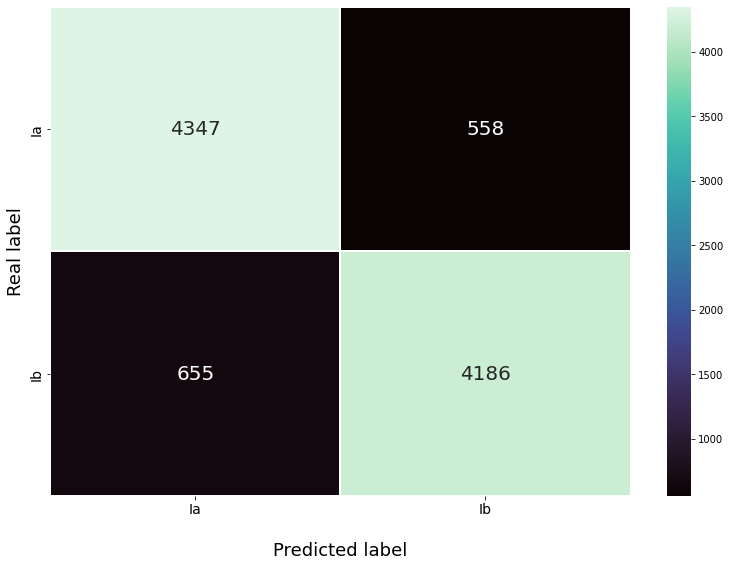

Kostya : Accuracy on testing sample is : 89.63%
Efficiency : 90.78% of real Ia were labeled as Ia
Purity : 88.85% of classified Ia were indeed Ia


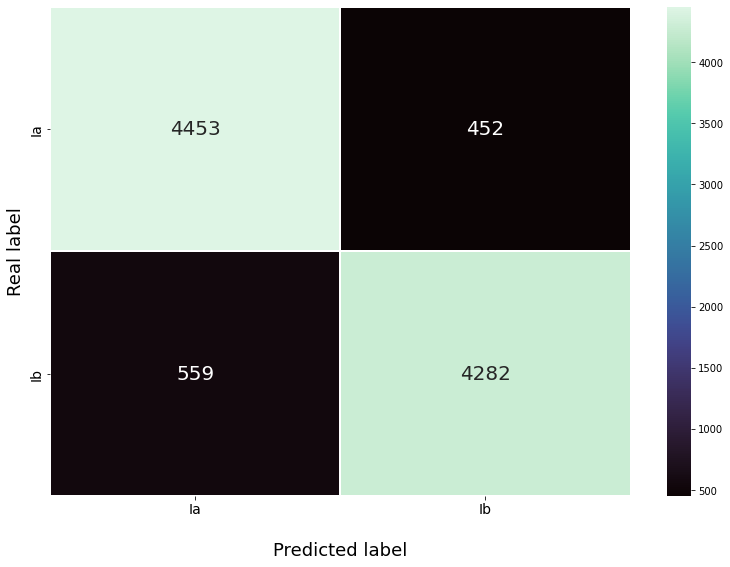

In [3]:
seed = 42

rf = {}

for features in methods:
    
    X_train, X_test, y_train, y_test = train_test_split(features[0].iloc[:,:-2], features[0]['target'], test_size=0.5, random_state=seed)
    clf = RandomForestClassifier(n_estimators = 100, random_state=seed)
    clf.fit(X_train, y_train)
    
    rf[features[1]] = clf

    score = clf.score(X_test, y_test)
    print(f'{features[1]} : Accuracy on testing sample is : {score*100:.2f}%')
    ct.draw_confusion(clf, X_test, y_test, interest='Ia')

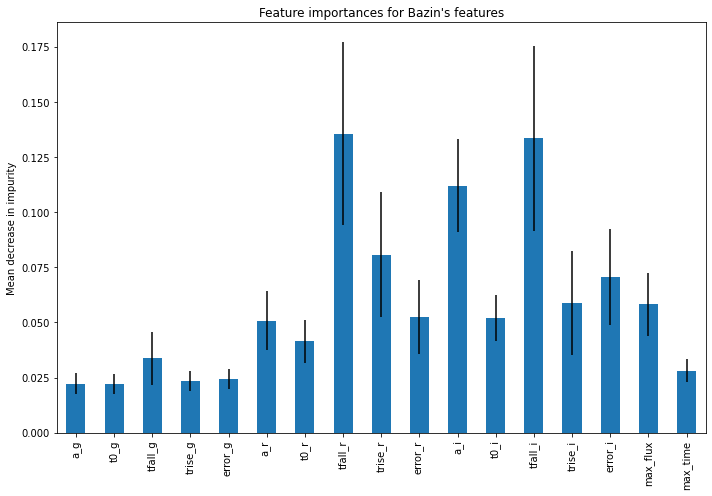

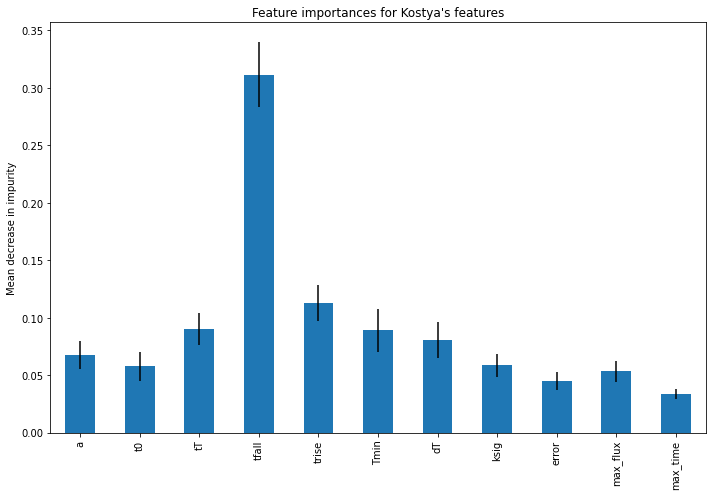

In [4]:
for idx, features in enumerate(methods):
    
    importances = rf[features[1]].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf[features[1]].estimators_], axis=0)

    forest_importances = pd.Series(importances, index=features[0].iloc[:, :-2].keys())
    fig, ax = plt.subplots(figsize = (10, 7))


    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Feature importances for {features[1]}'s features")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

# How good is t0 prediction

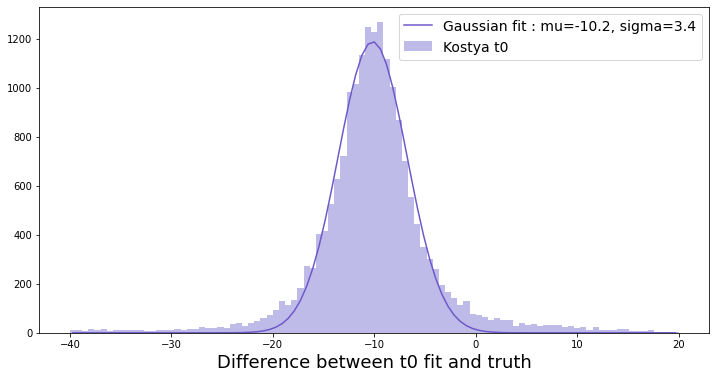

In [137]:
prediction = kostya_features['t0'] + kostya_features['max_time'] 
diff = prediction - kostya_features['true_peak']

bins = np.linspace(-40, 20, 100)

plt.figure(figsize =(12,6))
plt.xlabel("Difference between t0 fit and truth", fontsize = 18)

(n, b, patches) = plt.hist(diff, bins=bins, alpha=0.5, color='#7E78D2', label='Kostya t0');

width = b[1] - b[0]
center_bins = b[:-1]+(width/2)

parameters, covariance = curve_fit(Gauss, center_bins, n)

plt.plot(center_bins, Gauss(center_bins, *parameters), color='#6F58C9',\
             label=f"Gaussian fit : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

plt.legend(fontsize = 14)

# Predict the max peak using machine learning

[784.96841171  -1.77228755   7.29857889]
[8.76943476e+02 1.86446860e-01 6.24414731e+00]


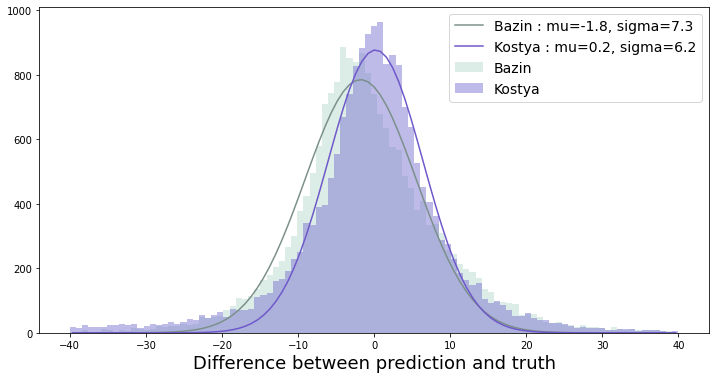

In [125]:
plt.figure(figsize =(12,6))
plt.xlabel("Difference between prediction and truth", fontsize = 18)

for features in methods:
    
    colors = ['#6F58C9', '#7E78D2']
    if features[1] == 'Bazin':
        colors = ['#7B908A', '#BBDBD1']
    
    X = features[0].iloc[:,:-2]
    y = features[0]['true_peak']
    reg = LinearRegression().fit(X, y)
    prediction = reg.predict(features[0].iloc[:,:-2])
    
    diff = prediction - y
    bins = np.linspace(-40, 40, 100)
    
    (n, b, patches) = plt.hist(diff, bins=bins, label=features[1], alpha=0.5, density=False, color=colors[1]);
    
    width = b[1] - b[0]
    center_bins = b[:-1]+(width/2)
    
    parameters, covariance = curve_fit(Gauss, center_bins, n)
    plt.plot(center_bins, Gauss(center_bins, *parameters), color=colors[0],\
             label=f"{features[1]} : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

    
plt.legend(fontsize = 14)
plt.show()